# Dependencies


In [4]:
pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

  Cloning https://github.com/meichenfang/velocyto.py.git to /tmp/pip-req-build-qa6cggrc
  Running command git clone -q https://github.com/meichenfang/velocyto.py.git /tmp/pip-req-build-qa6cggrc
     |████████████████████████████████| 41 kB 99 kB/s 
     |████████████████████████████████| 9.9 MB 7.0 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
  Created wheel for velocyto: filename=velocyto-0.17.16-cp37-cp37m-linux_x86_64.whl size=364634 sha256=aedaea69a9f0518b3fef029fe7cffb5515904e0ab3373a34d827eee59711fadf
  Stored in directory: /tmp/pip-ephem-wheel-cache-bl58mjbh/wheels/cd/c8/75/7316ac4e259c187f81cb3f26bddda1fd4968afd72f49be1c1c
  Created wheel for loompy: filename=loompy-3.0.6-py3-none-any.whl size=47905 sha256=c57e6d8e21ee037ab0ef50d7cec4b6c0eee53440417569dc857cbdc89c03ca56
  Stored in directory: /root/.cache/pip/wheels/aa/84/e5/38fa2e3b59faa40b027a12a0c2de64cd787a1cbf05725fb021
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.14-py3-none-any.whl siz

In [5]:
pip install scanpy

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
     |████████████████████████████████| 127 kB 45.3 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 58.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=5f8927e7a760b6ea4d44e93ceb73913c5efefeb7adc0881b4af3935fc37207bf
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=8c21228ca98d52cc83277bf6487e7227738ee9d877a03a1d9dadb5a0ecab48ab
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=cf4a30631c811496829007d578af66111ad161b7a027bbe4f970efdcbbca9246
  Stored in directory: /root/.cache/

In [3]:
pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=4305c437627a7d694282fc4d7e15b0373c089a1a21e85f3a6848c968c559a7dd
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [1]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "hgForebrainGlut.loom")

('hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7ff3366fdcd0>)

# vis.py

In [1]:
#For vlm need to save linear/non-linear pca,t-SNE,UMAP,  and true pseudotime/gamma, cluster labels

#!git clone https://github.com/pachterlab/GFCP_2021.git
#!cd GFCP_2021
#import vis 
#vis.makeEmbeds()....

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import velocyto as vcy

# parameter
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex] 
emb_dict={"default":'pcs',"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    

def makeEmbeds(vlm, embeds, x_name="S_norm",):
    '''
    Save embedding objects in embeds lists in vlm
    
    Parameters
    ----------
    vlm : Velocyto loompy object
    x_name: X for embedding, e.g. "S", "S_norm"
    embeds : set of embeddings e.g. {'PCA','UMAP','tSNE'}
    
    Returns
    -------
    '''
    
    X = getattr(vlm, x_name) # X=(n_samples, n_features)   
    vlm.PCA = PCA(n_components=50).fit_transform(X.T)
    
    if "PCA" in embeds:
        vlm.ps = np.array(vlm.PCA[:,:2], order="C")
        
    if 'UMAP' in embeds:
        vlm.us = umap.UMAP(n_components=2).fit_transform(vlm.PCA[:, :25])
        
    if 'tSNE' in embeds:
        vlm.ts = TSNE(n_components=2).fit_transform(vlm.PCA[:, :25]) 

    if "default" in embeds:
        vlm.perform_PCA(which=x_name)

    return 

def preprocess(vlm,nGene=1000):

    vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
    vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
    vlm.filter_genes(by_detection_levels=True)
    vlm.score_cv_vs_mean(N=nGene, plot=False, max_expr_avg=35)
    vlm.filter_genes(by_cv_vs_mean=True)

    vlm.normalize("both", size=True, log=True)
    vlm.perform_PCA(which="S_norm")
    return

def getImputed(vlm, knn_k=50):
    '''
    Get gamma inference from imputed counts
    
    Parameters
    ----------
    
    Returns
    -------
    '''

    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))
    vlm.normalize("imputed", size=True, log=True)

    #Get gamma inference
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=True, \
               weighted=True, weights="maxmin_diag", \
               maxmin_perc=[2,95], limit_gamma=True)
    delta_t = 1
    vlm.used_delta_t = delta_t
    velocity = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    vlm.delta_S = delta_t * velocity # same as vlm.calculate_shift()
    vlm.Sx_sz_t = vlm.Sx_sz + vlm.delta_S  # same as vlm.extrapolate_cell_at_t(delta_t=1)
    return vlm


def getNeighbors(embed, n_neigh = 150, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(vlm, embed1, embed2, n_neigh=150):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    emb_dict={"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    x1=getattr(vlm, emb_dict[embed1])
    x2=getattr(vlm, emb_dict[embed2])
    embed1_neighbor = getNeighbors(x1,n_neigh)
    embed2_neighbor = getNeighbors(x2,n_neigh)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        frac[i] = len(inter)/len(set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:]))
    return frac


# ---------------- Plotting -------------

def princCurvePlots(ax,vlm):
    '''
    Plot principle curve coordinates for linear PCA embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    return

def plotJaccard(ax,vlm,pair,n_neigh):
    '''
    Single jaccard distance plot
    
    Parameters
    ----------
    ax: plot axis
    vlm: velocyto 
    Returns
    -------
    '''
    frac=getJaccard(vlm, pair[0], pair[1],n_neigh)
    ax.hist(frac)
    ax.set_title('Jaccard distances for neighbors between ' + pair[0] + ' and '  + pair[1])
    return

def jaccardPlots(vlm,pairs,n_neigh):
    '''
    Plot jaccard distances for neighbors between pairs of embeddings
    
    Parameters
    ----------
    vlm: VelocytoLoom instance
    pairs: tuple of two element tuples, e.g (('ps','ts'),('ts','us'))
    n_neigh: number of neighbors

    Returns
    -------
    fig: figure
    
    '''
    emb_set=set(emb for pair in pairs for emb in pair)
    for emb in emb_set:
        if emb not in ("PCA","UMAP",'tSNE'):
            raise NameError('only support PCA, UMAP and tSNE')
    makeEmbeds(vlm, emb_set,x_name='Sx_sz')

    n=len(pairs)
    fig, ax = plt.subplots(1,n, figsize=(6*n,4))
    if n==1:
        plotJaccard(ax,vlm,pairs[0],n_neigh)
    else:
        for i in range(n):
            plotJaccard(ax[i],vlm, pairs[i],n_neigh)
    return


def plotPhase(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux_sz[gene_idx,:]
    x=vlm.Sx_sz[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    ax.plot(x, y, 'b.')
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    if k!=0:
        x0=np.minimum(np.amin(x),np.amin((y-b)/k))
        x1=np.maximum(np.amax(x),np.amax((y-b)/k))
    else:
        x0=np.min(x)
        x1=np.max(x)
    x_=np.array([x0,x1])
    ax.plot(x_, x_*k+b, 'r')
    return

def plotGammaK(ax, vlm, gene_idx, n_neigh, gamma):
    '''
    Plot gamma over k neighbors for gene at gene_idx
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    ax.plot(n_neigh, gamma)
    ax.set_xlabel("k neighbors")
    ax.set_ylabel("gamma")
    return

def phasePlots(vlm,n_neighs,genes):
    '''
    Plot phase portrais with gamma distributions for various genes across n_neighs
    
    Parameters
    ----------
    
    Returns
    -------
    '''
        
    m = len(genes)
    n = len(n_neighs)
    gammas = np.zeros((m,n))
    fig, ax = plt.subplots(m,n+1,figsize=((n+1)*6,m*4))
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    
    for j, knn_k in enumerate(n_neighs):      
        vlm.knn_imputation(k=knn_k, n_pca_dims=n_comps, balanced=True, 
                           b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), 
                           b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))
        
        vlm.normalize("imputed", size=True, log=True)
        
        vlm.fit_gammas(use_imputed_data=True, use_size_norm=True, \
               weighted=True, weights="maxmin_diag", \
               maxmin_perc=[2,95], limit_gamma=True)
        
        #For genes 1...n
        for i, gene in enumerate(genes):
            gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
            plotPhase(ax[i][j], vlm, gene_idx)
            gammas[i,j]=vlm.gammas[gene_idx]

    #Plot inferred gamma + line for upregulate cells
    for i, gene in enumerate(genes):
        gene_idx=np.where(vlm.ra['Gene']==gene)[0][0]
        plotGammaK(ax[i][n], vlm, gene_idx, n_neighs, gammas[i,:])

    return fig


def plotEmbed(ax,vlm,embed,c='gray'):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    ax.scatter(x[:,0],x[:,1],marker=".",c=c)
    return


def plotGrid(ax,vlm,gridx,gridv,trans,c='b'):
    '''
    Plot grid with arrows given embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    x=getattr(vlm, gridx)
    v=getattr(vlm, gridv)
    masks=vlm.total_p_mass>0.01
    ax.quiver(x[masks, 0], x[masks, 1], v[masks, 0], v[masks, 1], color=c, scale=10, label=trans)
    return


def gridArrowPlots(vlm,Trans,embed,sim=False):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
    emb=emb_dict[embed]
    fig,ax=plt.subplots(1,1)

    if sim and embed=="PCA":
        princCurvePlots(ax,vlm)

    if sim:
        plotEmbed(ax, vlm, emb, c=vlm.ca["time"])
    else:
        plotEmbed(ax, vlm, emb, c=vlm.ca["Clusters"])

    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                      n_neighbors=150, knn_random=False, sampled_fraction=1)
        vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
        vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
            
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25), n_neighbors=100)
        
        plotGrid(ax,vlm,"flow_grid","flow",trans,c=vermeer[i])
    plt.legend()




def plotTheta(ax, X, Y):
    '''
    Single angle deviation plot
    '''
    angles=np.sum(X*Y,axis=1)/( np.linalg.norm(X,axis=1) * np.linalg.norm(Y,axis=1) )
    ax.hist(np.arccos(angles),density=True)
    ax.set_xlabel("angle")
    ax.set_ylabel("density")
    return 

def angleDevPlots(vlm,Trans,n_neigh,embed,baseline):
    '''
    Plot angle deviations from transformations over varying neighbors for embedding (only compared to baseline)
    
    Parameters
    ----------

    Returns
    -------
    '''
    getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
    emb=emb_dict[embed]
    fig, ax= plt.subplots(len(Trans),len(n_neigh),figsize=(len(n_neigh)*6,len(Trans)*4))
 
    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                        n_neighbors=baseline, knn_random=False, sampled_fraction=1)
        vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
        vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
              
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        baseline_arrow=vlm.delta_embedding
          
        for j, k in enumerate(n_neigh):
            vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                          n_neighbors=k, knn_random=False, sampled_fraction=1)
            vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
                
            vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
            
            plotTheta(ax[i,j], baseline_arrow, vlm.delta_embedding)
        
    return






/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# Test

In [2]:
vlm = vcy.VelocytoLoom(loom_filepath="hgForebrainGlut.loom")
preprocess(vlm)

## phasePlots

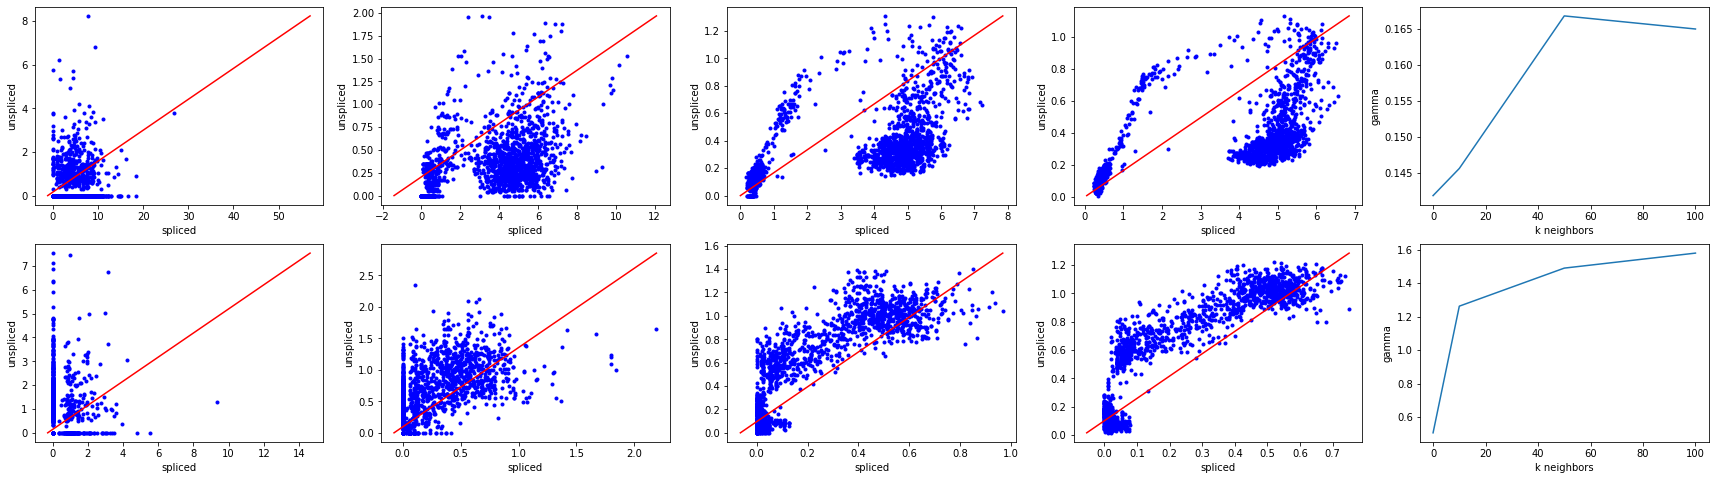

In [94]:
fig=phasePlots(vlm,n_neighs=[0,10,50,100],genes=["DCX","GRIA3"])

## jaccardPlots

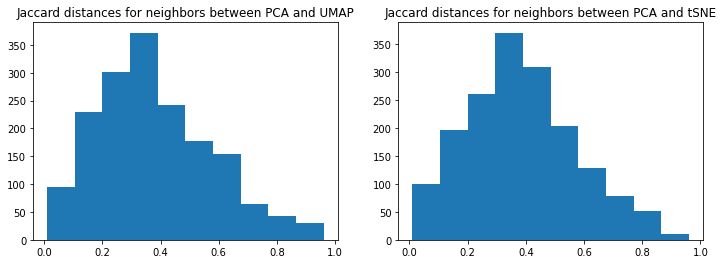

In [96]:
jaccardPlots(vlm,pairs=[["PCA","UMAP"],["PCA","tSNE"]],n_neigh=50)

## gridArrowPlots

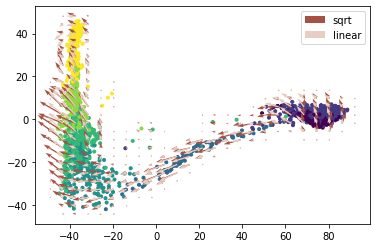

In [3]:
gridArrowPlots(vlm,Trans=["sqrt","linear"],embed="PCA",sim=False)

## angleDevPlots

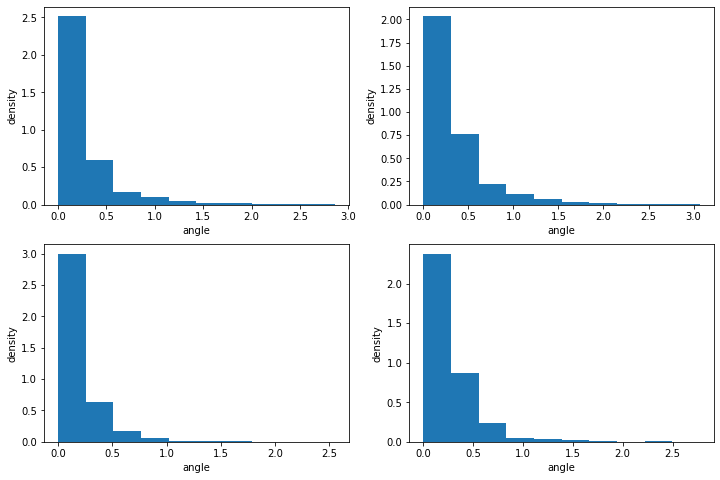

In [3]:
angleDevPlots(vlm,Trans=["sqrt","linear"],n_neigh=[100,150],embed="PCA",baseline=50)